<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/b__wide/experiments/b_wide/Implement/tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 開発用モジュール

In [12]:
import gc
def refresh(model):
  del model
  gc.collect()

In [11]:
import matplotlib.pyplot as plt
import cv2
def display_ndarray(image):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()

In [10]:
from tensorflow.keras import layers, models, initializers, callbacks
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import plot_model

# [A-2]環境構築

In [2]:
#@title gdrive マウント
from google.colab import drive
from os import path
if not path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm")


Mounted at /content/drive


In [3]:
#@title 一時的にファイルを置くディレクトリ'desk'を作成
import os
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)

In [9]:
#@title 必要なモジュールを'desk'にコピー

wants_paths = [
'/content/drive/MyDrive/colab/dence1223/key20201218.h5',
'/content/drive/MyDrive/colab/dence1223/normalTrainLabels.npz',
'/content/drive/MyDrive/colab/dence1223/normalTrainVideos.npz',
'/content/drive/MyDrive/colab/dence1223/normalTestLabels.npz',
'/content/drive/MyDrive/colab/dence1223/normalTestVideos.npz',
]

import shutil
for want in wants_paths:
  shutil.copy2(want, desk)
            

In [4]:
#@title データフォーマットを規定
class video_format:
  name = "video_format"
  # サンプリングされたCMデータの仕様
  playtime = "15秒"
  displaysize = "(any, any, RGB)"
  videoformat = "any"
  # モデルが扱うCMデータ(上のようなデータは、下のように変換される)
  HEIGHT = 45
  WIDTH = 80
  FRAME_SIZE = 30
  COLOR = "RGB"
  FPS = "2 (FRAME_SIZE / playtime)" # 定義ではなく上から導かれた値
  
format1 = video_format()

# [A-1]データ取得・整形

## [A-1-1]データ取得

In [11]:
path_trainData = "/content/drive/MyDrive/train_data"
path_testData = "/content/drive/MyDrive/test_data"

import os
if not os.path.isdir(path_trainData):
  print("no train data")
if not os.path.isdir(path_testData):
  print("no test data")

In [12]:
class DataWithLabel:
  data = "video data"
  label = "train label"
  def __init__(self, data, label):
    self.data = data
    self.label = label

In [13]:
# ディレクトリ名とラベルとの対応
ruleLabel = {
    '0.other' : 0, 
    '1.food' : 1,
    '2.car' : 2,
    '3.cosme' : 3
    }

In [ ]:
#@title 訓練データ取得
import os
import cv2

dwls = []

dir_classes = os.listdir(path_trainData)
for dir_class in dir_classes:
  print(dir_class)
  path_dir_class = os.path.join(path_trainData, dir_class)
  videosInTheClass = os.listdir(path_dir_class)
  for videoInTheClass in videosInTheClass:
    path_videoInTheClass = os.path.join(path_dir_class, videoInTheClass)
    print(path_videoInTheClass) # 扱うビデオデータのパスを確認
    video_cvformat = cv2.VideoCapture(path_videoInTheClass)
    label = ruleLabel[dir_class]
    print("Attached the label :", label)

    dwl = DataWithLabel(video_cvformat, label)
    dwls.append(dwl)
    print("________")


In [14]:
#@title テストデータ取得
import os
import cv2

dwls_test = []

dir_classes = os.listdir(path_testData)
for dir_class in dir_classes:
  print(dir_class)
  path_dir_class = os.path.join(path_testData, dir_class)
  videosInTheClass = os.listdir(path_dir_class)
  for videoInTheClass in videosInTheClass:
    path_videoInTheClass = os.path.join(path_dir_class, videoInTheClass)
    print(path_videoInTheClass) # 扱うビデオデータのパスを確認
    video_cvformat = cv2.VideoCapture(path_videoInTheClass)
    label = ruleLabel[dir_class]
    print("Attached the label :", label)

    dwl = DataWithLabel(video_cvformat, label)
    dwls_test.append(dwl)
    print("________")


1.food
/content/drive/MyDrive/test_data/1.food/SUNTORY_オールフリー.mpg
Attached the label : 1
________
/content/drive/MyDrive/test_data/1.food/Asahi_カルピスウォーター.mpg
Attached the label : 1
________
/content/drive/MyDrive/test_data/1.food/NISSIN_チキンラーメン_30秒.mpg
Attached the label : 1
________
/content/drive/MyDrive/test_data/1.food/House_C1000ビタミンレモン.mpg
Attached the label : 1
________
/content/drive/MyDrive/test_data/1.food/Asahi_澄みきるサイダー.mpg
Attached the label : 1
________
/content/drive/MyDrive/test_data/1.food/Ajinomoto_TossSala.mpg
Attached the label : 1
________
/content/drive/MyDrive/test_data/1.food/House_完熟トマトのハヤシライスソース.mpg
Attached the label : 1
________
/content/drive/MyDrive/test_data/1.food/NISSIN_チキンラーメン.mpg
Attached the label : 1
________
/content/drive/MyDrive/test_data/1.food/House_ジャワカレー.mpg
Attached the label : 1
________
/content/drive/MyDrive/test_data/1.food/SUNTORY_伊右衛門.mp4
Attached the label : 1
________
/content/drive/MyDrive/test_data/1.food/Calbee_ポテトチップスクリプス.m

## [A-1-2]データ整形

### [A-1-2-1]訓練データ整形

In [ ]:
#@title データ整形
import numpy as np
import math

for count_dwl, dwl in enumerate(dwls):
  print("loading : ", count_dwl)
  framesize = int(dwl.data.get(cv2.CAP_PROP_FRAME_COUNT)) # フレームの数
  cutTiming = math.floor(framesize / format1.FRAME_SIZE)

  cutTail = cutTiming * format1.FRAME_SIZE

  normalVideo = []
  count = 0
  # フレーム３０枚分を１つの動画から間伐する
  while count <= cutTail - 1:
    IO, frame = dwl.data.read()
    if (count % cutTiming) == 0: 
      if not IO:
        print("error in : ", count_dwl) 
        break
      else: 
        fixedFrame = cv2.resize(frame, dsize=(format1.WIDTH, format1.HEIGHT))
        normalVideo.append(fixedFrame)
    else:
      pass

    count += 1

  dwl.data = np.array(normalVideo)

In [ ]:
#@title 無作為抽出して確認
picks = [39, 40, 89, 112]

for pick in picks:
  sample = dwls[pick].data
  print(pick)
  for i in range(30):
    display_ndarray(sample[i])

In [18]:
#@title 整形データを保存
videos = []
labels = []
for dwl in dwls:
  videos.append(dwl.data)
  labels.append(dwl.label)
  
np.savez(os.path.join(desk, 'normalTrainVideos'), *videos)
np.savez(os.path.join(desk, 'normalTrainLabels'), *labels)

試しに読み込んでみる

In [ ]:
import numpy as np

v = np.load('/content/desk/normalTrainVideos.npz')
oneVideo = v['arr_0']
display_ndarray(oneVideo[10])

### [A-1-2-2]テストデータ整形

In [15]:
#@title データ整形
import numpy as np
import math

for count_dwl, dwl in enumerate(dwls_test):
  print("loading : ", count_dwl)
  framesize = int(dwl.data.get(cv2.CAP_PROP_FRAME_COUNT)) # フレームの数
  cutTiming = math.floor(framesize / format1.FRAME_SIZE)

  cutTail = cutTiming * format1.FRAME_SIZE

  normalVideo = []
  count = 0
  # フレーム３０枚分を１つの動画から間伐する
  while count <= cutTail - 1:
    IO, frame = dwl.data.read()
    if (count % cutTiming) == 0: 
      if not IO:
        print("error in : ", count_dwl) 
        break
      else: 
        fixedFrame = cv2.resize(frame, dsize=(format1.WIDTH, format1.HEIGHT))
        normalVideo.append(fixedFrame)
    else:
      pass

    count += 1

  dwl.data = np.array(normalVideo)
print("Complete.")

loading :  0
loading :  1
loading :  2
loading :  3
loading :  4
loading :  5
loading :  6
loading :  7
loading :  8
loading :  9
loading :  10
loading :  11
loading :  12
loading :  13
loading :  14
loading :  15
loading :  16
loading :  17
loading :  18
loading :  19
loading :  20
loading :  21
loading :  22
loading :  23
loading :  24
loading :  25
loading :  26
loading :  27
loading :  28
loading :  29
loading :  30
loading :  31
loading :  32
loading :  33
loading :  34
loading :  35
loading :  36
loading :  37
loading :  38
loading :  39
loading :  40
loading :  41
loading :  42
loading :  43
loading :  44
loading :  45
loading :  46
loading :  47
loading :  48
loading :  49
loading :  50
loading :  51
loading :  52
loading :  53
loading :  54
loading :  55
loading :  56
loading :  57
loading :  58
loading :  59
loading :  60
loading :  61
loading :  62
loading :  63
loading :  64
loading :  65
loading :  66
loading :  67
loading :  68
loading :  69
loading :  70
loading :  71
lo

39


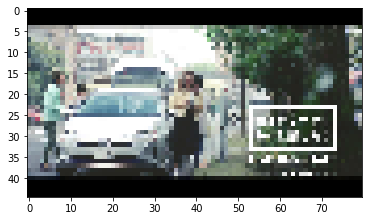

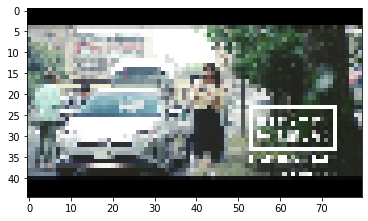

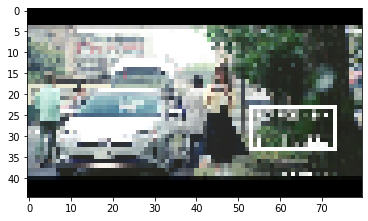

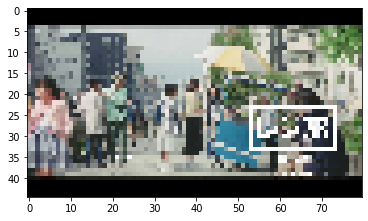

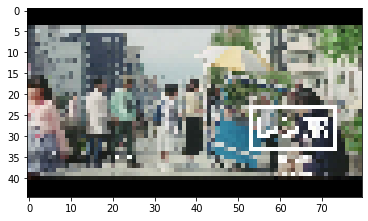

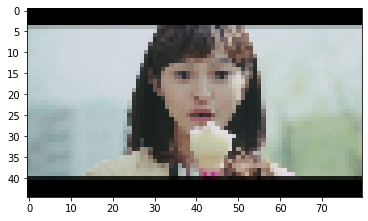

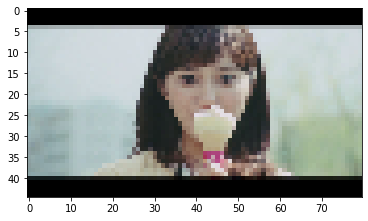

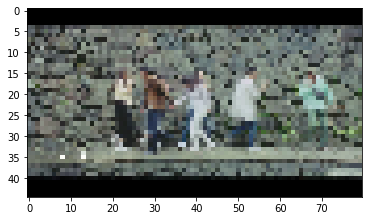

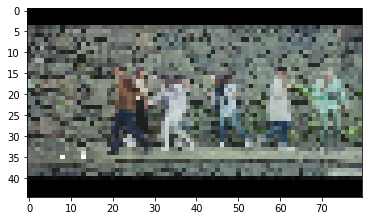

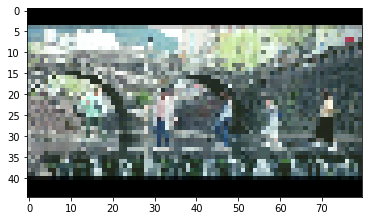

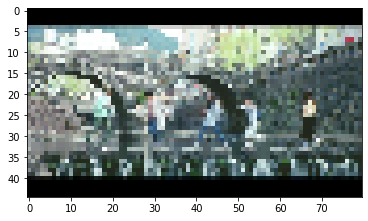

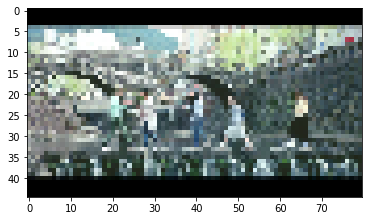

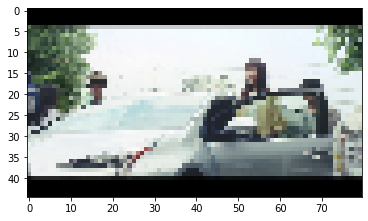

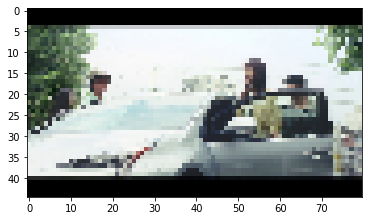

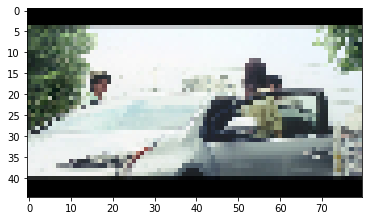

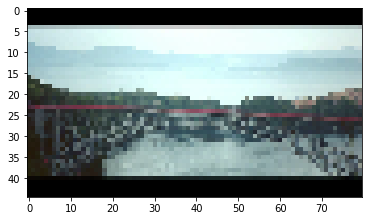

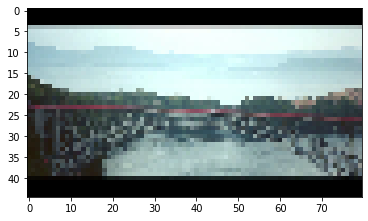

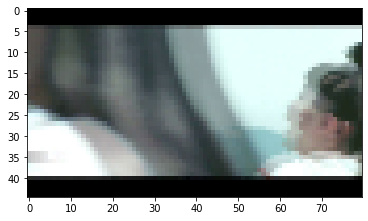

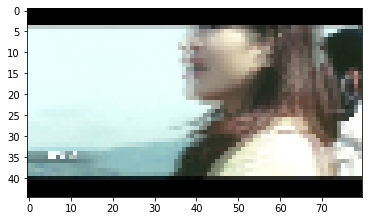

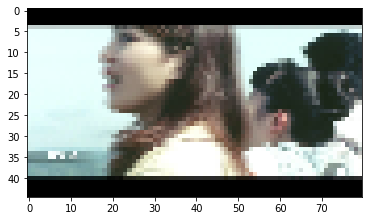

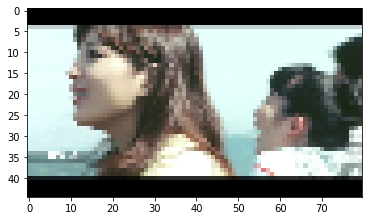

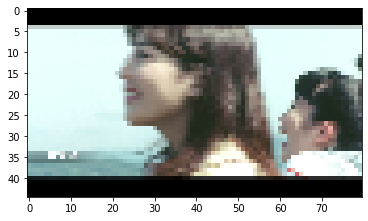

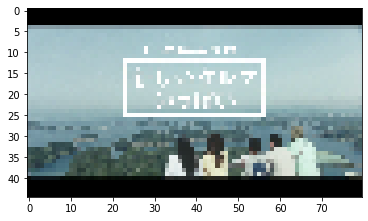

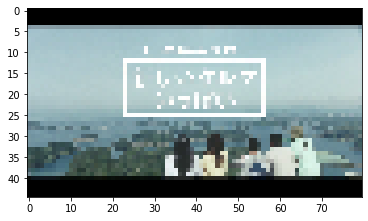

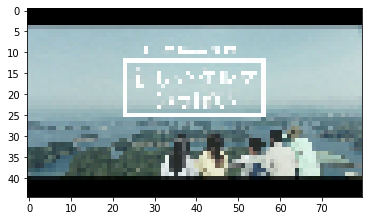

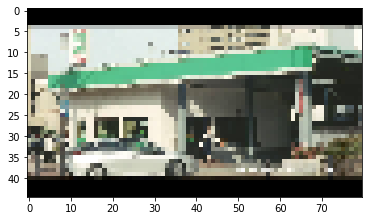

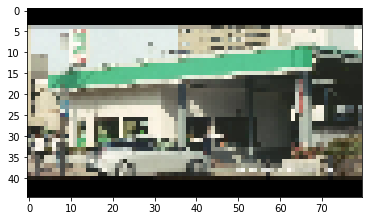

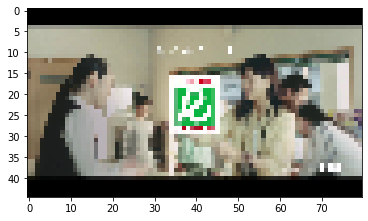

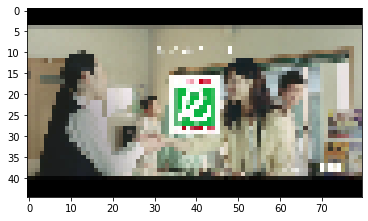

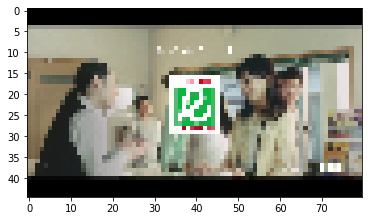

40


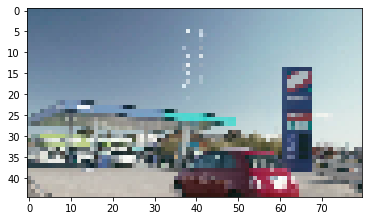

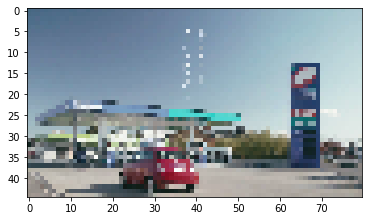

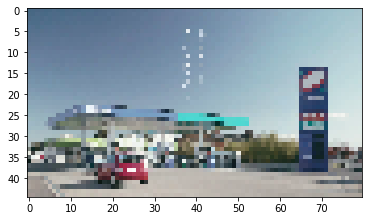

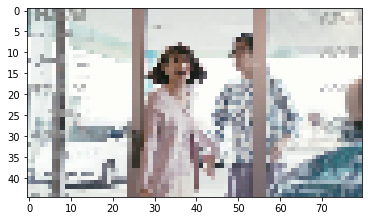

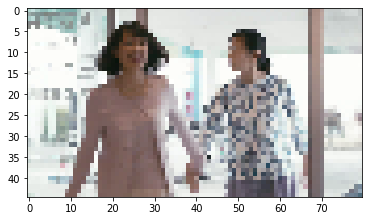

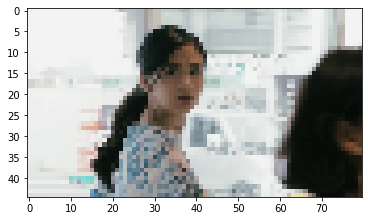

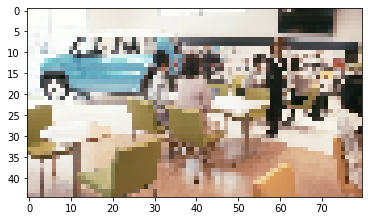

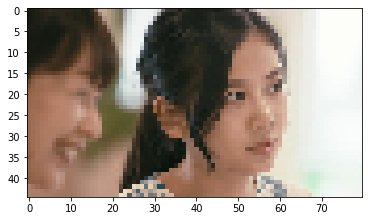

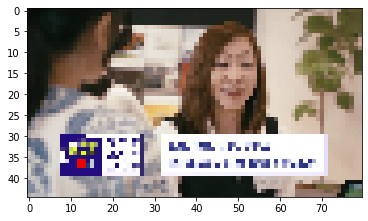

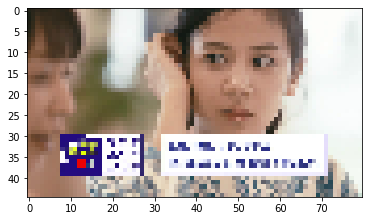

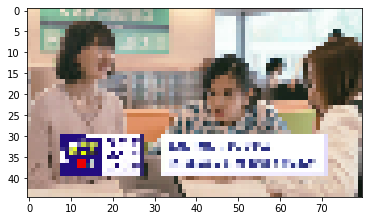

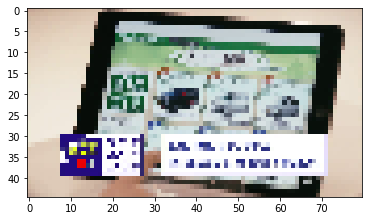

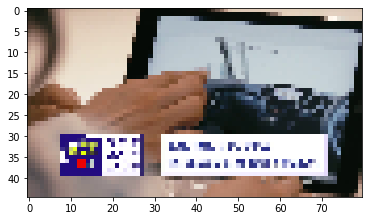

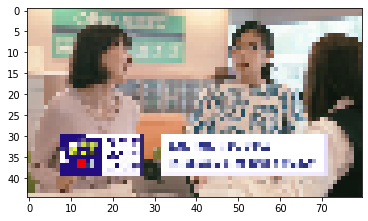

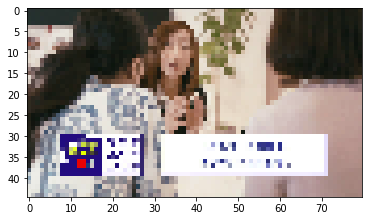

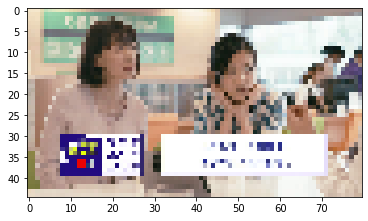

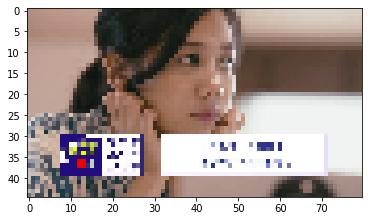

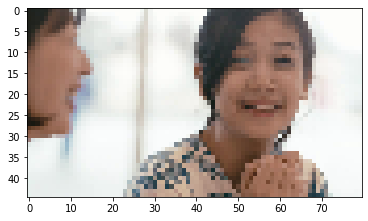

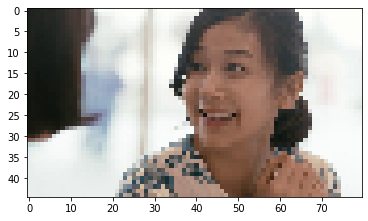

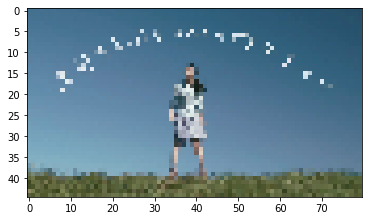

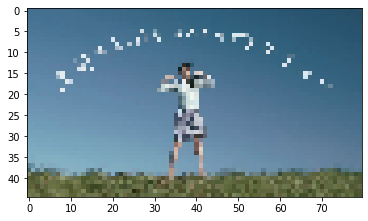

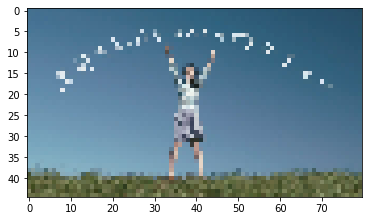

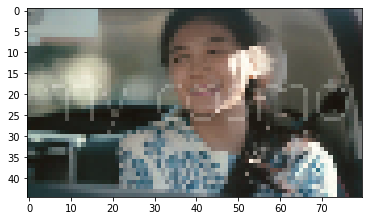

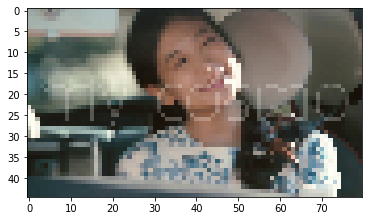

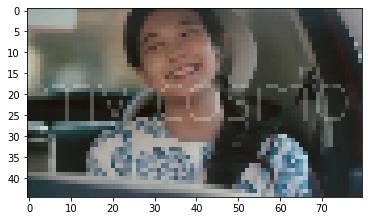

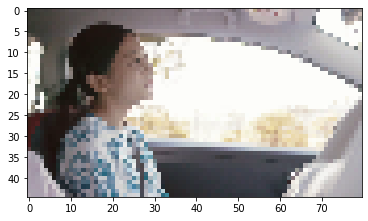

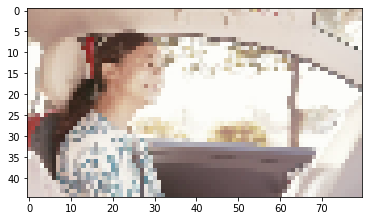

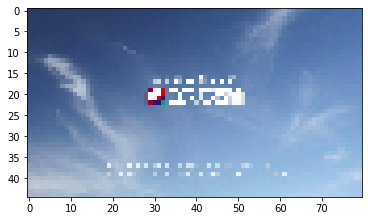

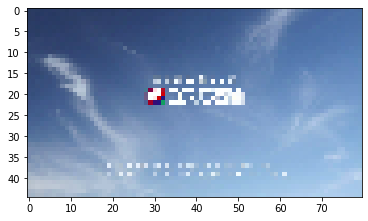

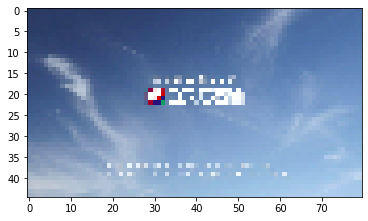

89


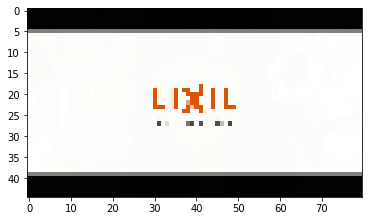

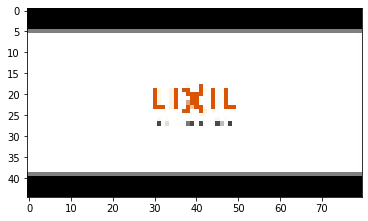

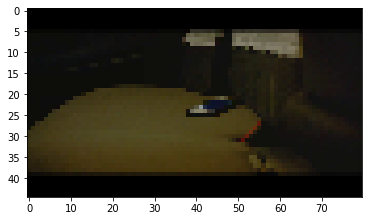

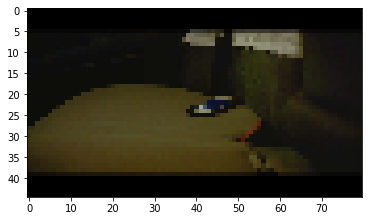

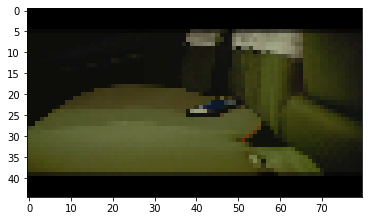

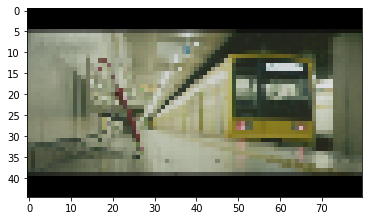

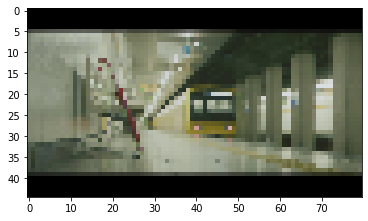

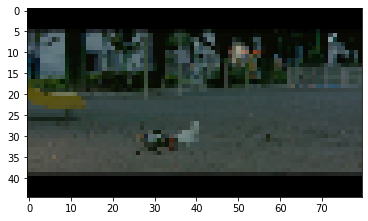

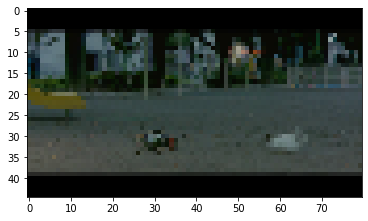

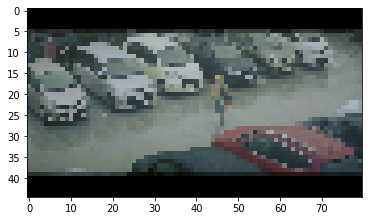

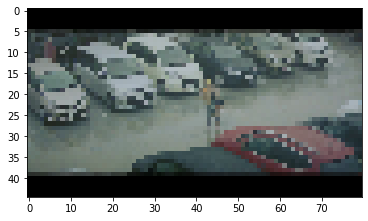

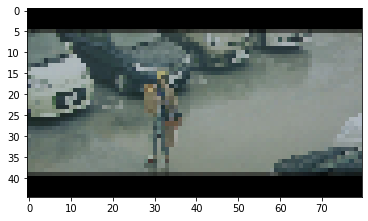

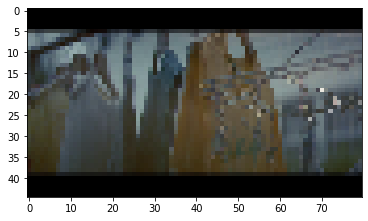

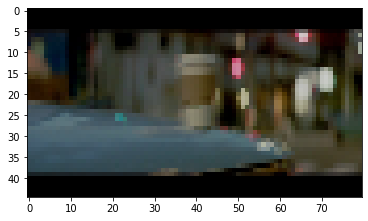

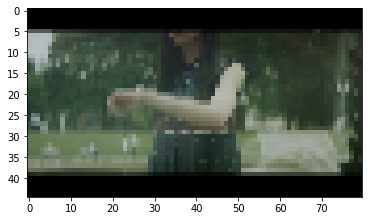

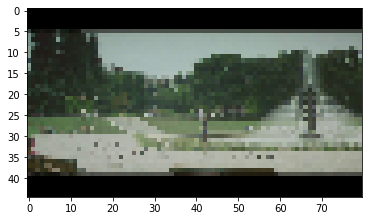

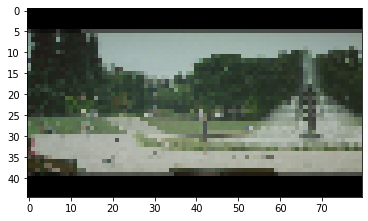

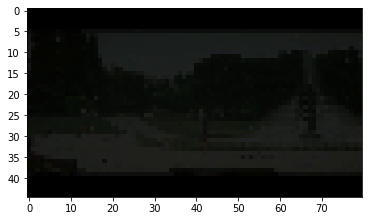

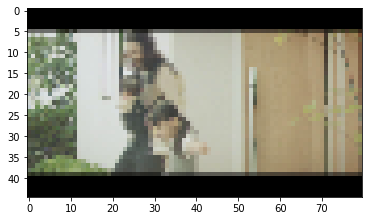

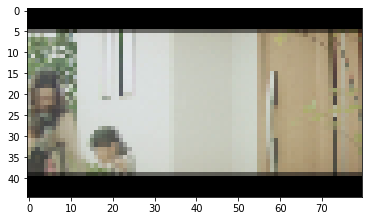

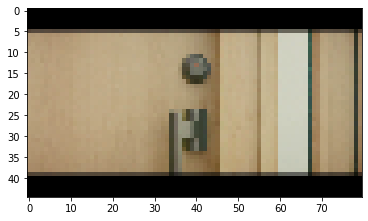

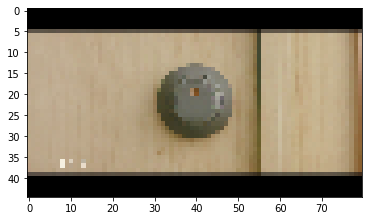

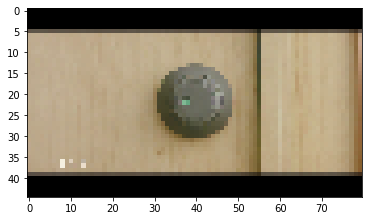

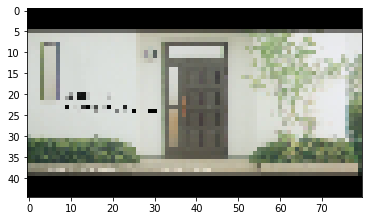

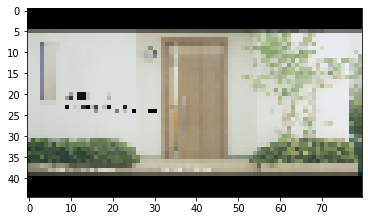

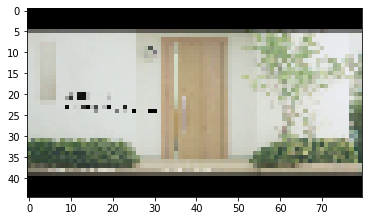

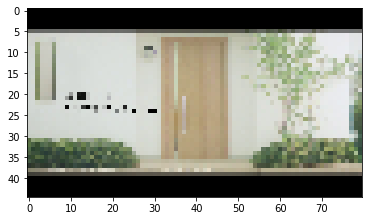

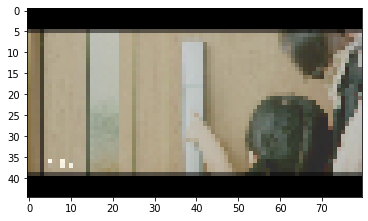

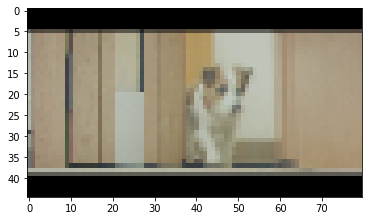

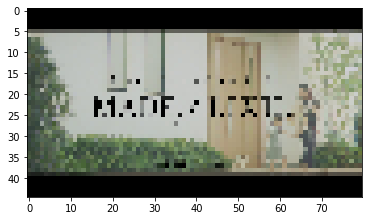

112


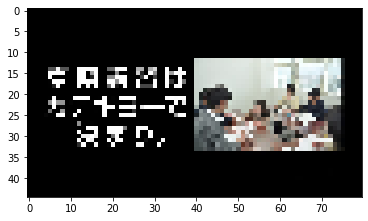

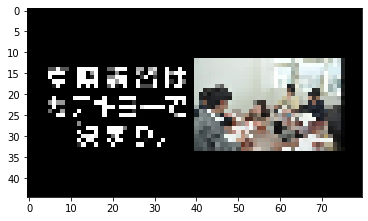

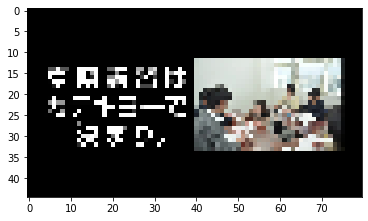

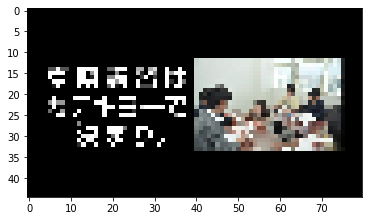

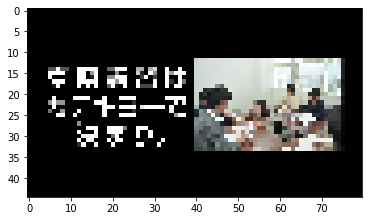

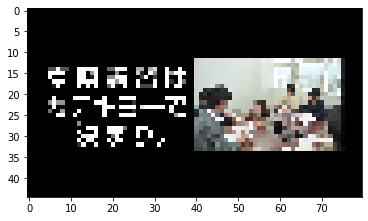

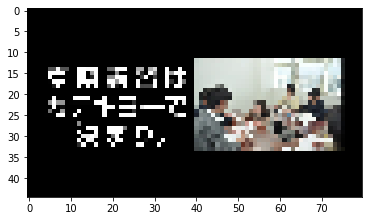

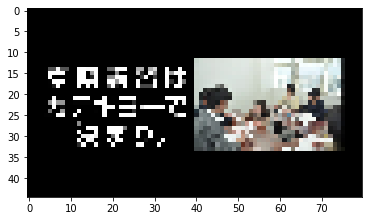

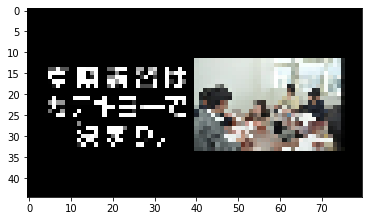

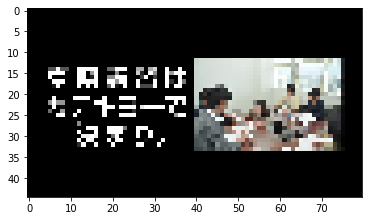

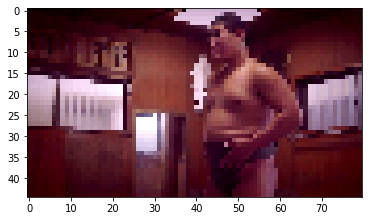

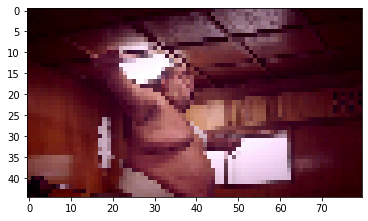

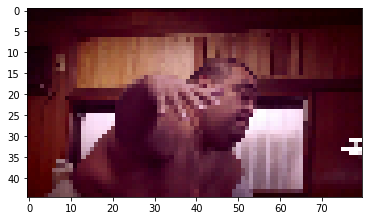

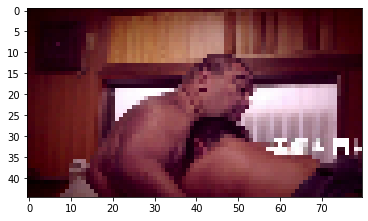

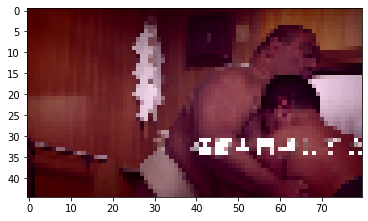

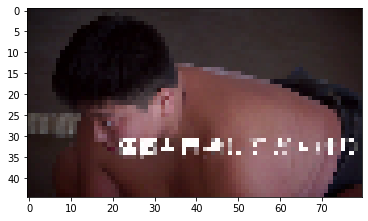

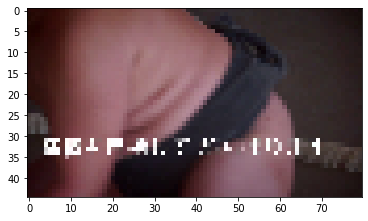

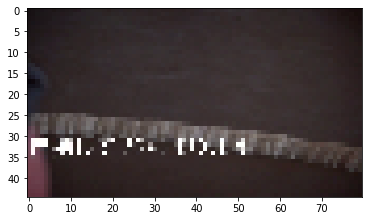

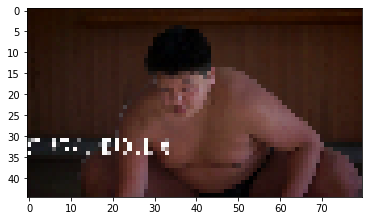

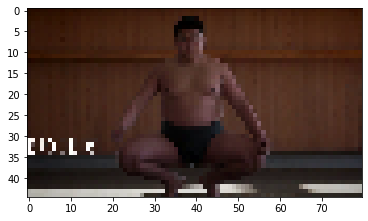

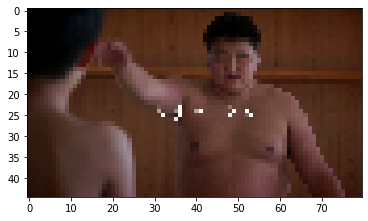

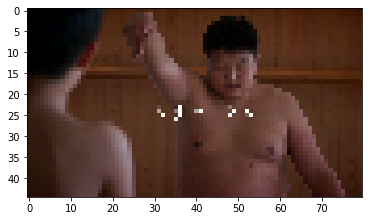

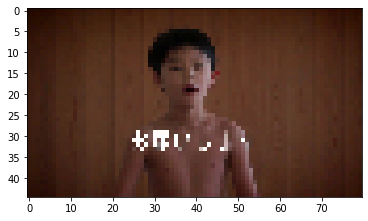

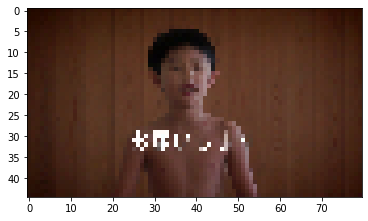

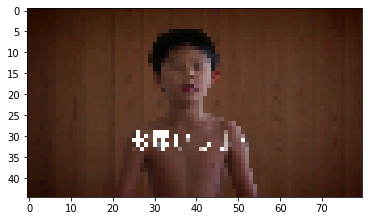

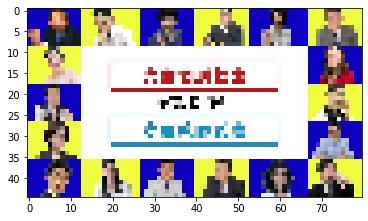

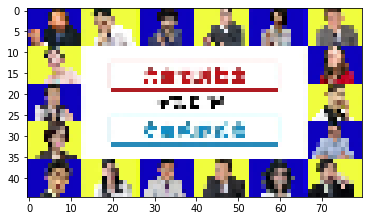

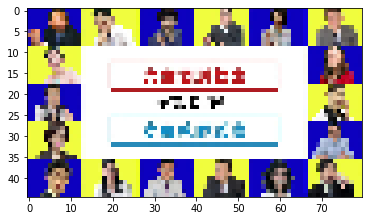

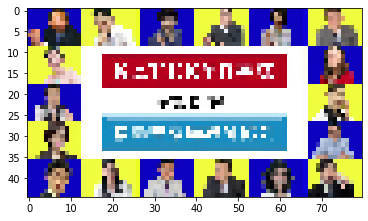

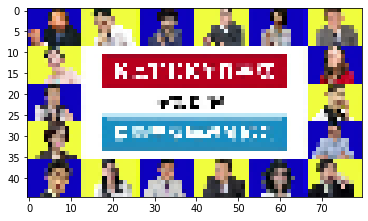

In [16]:
#@title 無作為抽出して確認
picks = [39, 40, 89, 112]

for pick in picks:
  sample = dwls_test[pick].data
  print(pick)
  for i in range(30):
    display_ndarray(sample[i])

In [17]:
#@title 整形データを保存
videos = []
labels = []
for dwl in dwls_test:
  videos.append(dwl.data)
  labels.append(dwl.label)
  
np.savez(os.path.join(desk, 'normalTestVideos'), *videos)
np.savez(os.path.join(desk, 'normalTestLabels'), *labels)

In [ ]:
import numpy as np

v = np.load('/content/desk/normalTestVideos.npz')
oneVideo = v['arr_7']
display_ndarray(oneVideo[2])

# [A-3]モデルの作成

In [26]:
#@title 入力データの情報を規定
colorSet = {'BW' : 1, 'RGB' : 3}

#入力層の設定
input_frameWIDTH = format1.WIDTH
input_frameHEIGHT = format1.HEIGHT
input_frameSIZE = format1.FRAME_SIZE
input_frameCOLOR = colorSet['RGB']
input_allPattern = input_frameWIDTH * input_frameHEIGHT * input_frameSIZE * input_frameCOLOR

print(
    input_frameWIDTH,
    input_frameHEIGHT,
    input_frameSIZE,
    input_frameCOLOR,
    input_allPattern )

80 45 30 3 324000


## [A-3-2]モデルの作成

In [23]:
from tensorflow.keras import layers, models, initializers, callbacks
import tensorflow as tf
import numpy as np

seedKey = 20201218

np.random.seed(seedKey)
tf.random.set_seed(seedKey)

model = models.Sequential([
    # 入力層        
    layers.Reshape(
        (input_frameSIZE, input_frameHEIGHT, input_frameWIDTH,  input_frameCOLOR), 
        input_shape=(input_allPattern,),
        name='ENTRANCE' ),
    # 中間層
    layers.Flatten(
        name='RIVER' ),
    layers.Dense(
      1024, # 1024項
      activation='relu',
      name='DAM' ),
    # 出力層
    layers.Dense(4, activation='softmax', name='WATERSUPPLY')
])

name_model = 'key' + str(seedKey)
name_model = name_model + '.h5'
path_model = os.path.join('/content/desk/', name_model)
model.save(path_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ENTRANCE (Reshape)           (None, 30, 45, 80, 3)     0         
_________________________________________________________________
RIVER (Flatten)              (None, 324000)            0         
_________________________________________________________________
DAM (Dense)                  (None, 1024)              331777024 
_________________________________________________________________
WATERSUPPLY (Dense)          (None, 4)                 4100      
Total params: 331,781,124
Trainable params: 331,781,124
Non-trainable params: 0
_________________________________________________________________


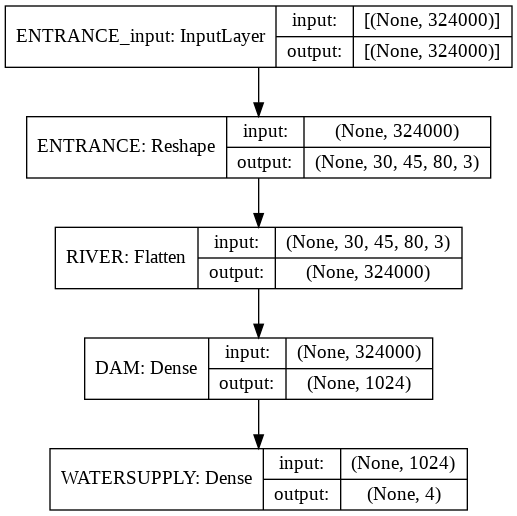

In [24]:
#表示
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(
  model,
  show_shapes=True,
  )

In [ ]:
refresh(model)

# [A-4]学習

## [A-4-1]データ用意


In [5]:
#@title 入力データの情報を規定
colorSet = {'BW' : 1, 'RGB' : 3}

#入力層の設定
input_frameWIDTH = format1.WIDTH
input_frameHEIGHT = format1.HEIGHT
input_frameSIZE = format1.FRAME_SIZE
input_frameCOLOR = colorSet['RGB']
input_allPattern = input_frameWIDTH * input_frameHEIGHT * input_frameSIZE * input_frameCOLOR

print(
    input_frameWIDTH,
    input_frameHEIGHT,
    input_frameSIZE,
    input_frameCOLOR,
    input_allPattern )

80 45 30 3 324000


### [A-4-1-1]訓練データ用意


In [6]:
#@title 訓練データ用意
import numpy as np

v = np.load('/content/desk/normalTrainVideos.npz')
l = np.load('/content/desk/normalTrainLabels.npz')

In [7]:
train_videos = []
train_labels = []
for i in v.files:
  train_videos.append(v[i])
for i in l.files:
  train_labels.append(l[i])

train_videos = np.array(train_videos)
train_labels = np.array(train_labels)

見てみる

In [8]:
sample = train_videos[8]
image1 = sample[1]
display_ndarray(image1)

print(len(train_videos) == len(train_labels))

NameError: ignored

In [13]:
# データを一列にする
train_videos = train_videos.reshape(len(train_videos), input_allPattern).astype('float32')/255
train_labels = tf.keras.utils.to_categorical(train_labels, 4)
print(train_videos.shape)

(129, 324000)


### [A-4-1-2]テストデータ用意


In [14]:
#@title テストデータ用意
import numpy as np

v = np.load('/content/desk/normalTestVideos.npz')
l = np.load('/content/desk/normalTestLabels.npz')

In [15]:
test_videos = []
test_labels = []
for i in v.files:
  test_videos.append(v[i])
for i in l.files:
  test_labels.append(l[i])

test_videos = np.array(test_videos)
test_labels = np.array(test_labels)

見てみる

In [ ]:
sample = test_videos[8]
image1 = sample[1]
display_ndarray(image1)

print(len(test_videos) == len(test_labels))

In [16]:
# データを一列にする
test_videos = test_videos.reshape(len(test_videos), input_allPattern).astype('float32')/255
test_labels = tf.keras.utils.to_categorical(test_labels, 4)
print(test_videos.shape)

(124, 324000)


## [A-4-2]モデル用意


In [ ]:
#@title モデル用意
from tensorflow.keras.utils import plot_model
model = models.load_model('/content/desk/key20201218.h5')
model.summary()
plot_model(
  model,
  show_shapes=True,
  )

## 学習

In [22]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
assert loss.shape == (2,)
loss.numpy()

array([0.05129331, 2.3025851 ], dtype=float32)

In [19]:
from keras import losses

In [38]:
losses = {
    'CEE' : 'categorical_crossentropy',
    'MSE' : 'mean_squared_error',
    'MSLE' : 'mean_squared_logarithmic_error',
    'MAE' : 'mean_absolute_error',
}
def inverse_dict(d):
    return {v:k for k,v in d.items()}

inv_losses = inverse_dict(losses)


pick_loss = losses['MSE']

In [18]:
#@title 学習方法の設定
model.compile(
    optimizer='adam', 
    loss = 'mean_squared_error',
    metrics=['acc'])

In [19]:
#@title 学習
%%time
history = model.fit(
      train_videos, 
      train_labels, 
      validation_data=(test_videos, test_labels),
      batch_size=8,
      epochs=64
      )
print("Complete.")

Epoch 1/64
17/17 [==============================] - 2s 104ms/step - loss: 2.3796 - acc: 0.3101 - val_loss: 371.2444 - val_acc: 0.4516
Epoch 2/64
17/17 [==============================] - 1s 85ms/step - loss: 1.7311 - acc: 0.4505 - val_loss: 129.2951 - val_acc: 0.4355
Epoch 3/64
17/17 [==============================] - 1s 86ms/step - loss: 1.1296 - acc: 0.5848 - val_loss: 97.8558 - val_acc: 0.3145
Epoch 4/64
17/17 [==============================] - 1s 84ms/step - loss: 1.1038 - acc: 0.5142 - val_loss: 169.2319 - val_acc: 0.3548
Epoch 5/64
17/17 [==============================] - 1s 84ms/step - loss: 1.1459 - acc: 0.4785 - val_loss: 210.7757 - val_acc: 0.4355
Epoch 6/64
17/17 [==============================] - 1s 85ms/step - loss: 0.9215 - acc: 0.6128 - val_loss: 155.7925 - val_acc: 0.4113
Epoch 7/64
17/17 [==============================] - 1s 85ms/step - loss: 0.8313 - acc: 0.6791 - val_loss: 204.0549 - val_acc: 0.4516
Epoch 8/64
17/17 [==============================] - 1s 85ms/step - lo

# [A-5]学習の評価

In [27]:
from pandas import DataFrame
import matplotlib.pyplot as plt


def savePlot(fig, plus):
  # name = inv_losses[pick_loss]
  name = 'tmp'
  name = name + '_' + plus
  path_image = os.path.join(desk, name)
  fig.savefig(path_image)

def plotAcc(history):
  fig = plt.figure()
  ACC = fig.add_subplot(1,1,1)
  props = {
      'title' : 'plot of ACCURACY',
      'xlabel' : 'epoch',
      'ylabel' : 'value'
  }
  ACC.set(**props)
  acc = DataFrame(history.history['acc'])
  val_acc = DataFrame(history.history['val_acc'])
  ACC.plot(acc, label='acc', marker='o', color='blue')
  ACC.plot(val_acc, label='val_acc', marker='o', linestyle='--', color='orange')
  ACC.legend()

  savePlot(fig, 'acc')

def plotLoss(history):
  fig = plt.figure()
  LOSS = fig.add_subplot(1,1,1)
  props = {
      'title' : 'plot of LOSS',
      'xlabel' : 'epoch',
      'ylabel' : 'value'
  }
  LOSS.set(**props)
  loss = DataFrame(history.history['loss'])
  val_loss = DataFrame(history.history['val_loss'])
  LOSS.plot(loss, label='loss', marker='o', color='blue')
  LOSS.plot(val_loss, label='val_loss', marker='o', linestyle='--', color='orange')
  LOSS.legend()

  savePlot(fig, 'loss')

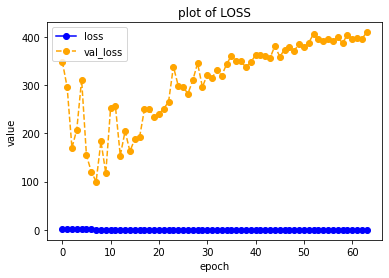

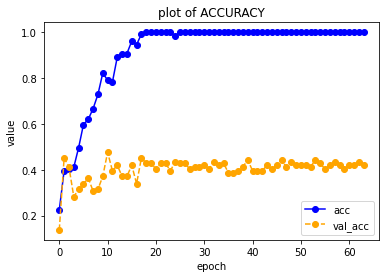

In [39]:
#@title accuracy, loss 描画
plotLoss(history)
plotAcc(history)

#ストレージへ保存

In [18]:
shelf = '/content/drive/MyDrive/colab'
book = 'dence1223'
shelf_book = os.path.join(shelf, book)
if not os.path.exists(shelf_book):
  os.mkdir(shelf_book)

wants_paths = [
'/content/desk/normalTestLabels.npz',
'/content/desk/normalTestVideos.npz'
]

import shutil
for want in wants_paths:
  shutil.copy2(
      want,
      shelf_book
  )
            

# [A-6]テスト